# Whole-brain analyses

In [1]:
%matplotlib inline

In [2]:
import os
import os.path as op
import shutil

import numpy as np
import nibabel as nib
import moss

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import lyman

In [3]:
os.environ["LYMAN_DIR"] = op.abspath("../lyman/")
analysis_dir = lyman.gather_project_info()["analysis_dir"]

In [4]:
from punch_utils import SlicePlotter, SurfacePlotter, estimate_roi_firs

In [5]:
sns.set(style="ticks", context="paper",
        rc={"xtick.major.size": 3, "ytick.major.size": 3,
            "xtick.major.width": 1, "ytick.major.width": 1,
            "axes.linewidth": 1, "lines.linewidth": 1})
mpl.rcParams["savefig.dpi"] = 150

In [6]:
def savefig(fig, name):
    fig.savefig("figures/{}.pdf".format(name), dpi=120)
    fig.savefig("figures/{}.png".format(name), dpi=120)
    fig.savefig("tiffs/{}.tiff".format(name), dpi=300)

In [7]:
model = "cpe_main"
experiment = "punch-" + model

---

## Parametric effect of CPE

In [8]:
slicer = SlicePlotter(model, "cpe", sharp=True, stat_cmap="BuGn_r", stat_range=(2, 5))

In [9]:
cortex = SurfacePlotter(model, "cpe")
cortex.add_data(colormap="BuGn_r", thresh=2.3, min=2, max=5, alpha=.9)
cortex.save_views("lat", "fro", "med", "par")
cortex.close()

/Users/mwaskom/anaconda/envs/punch/lib/python2.7/site-packages/traits/has_traits.py:1766: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )


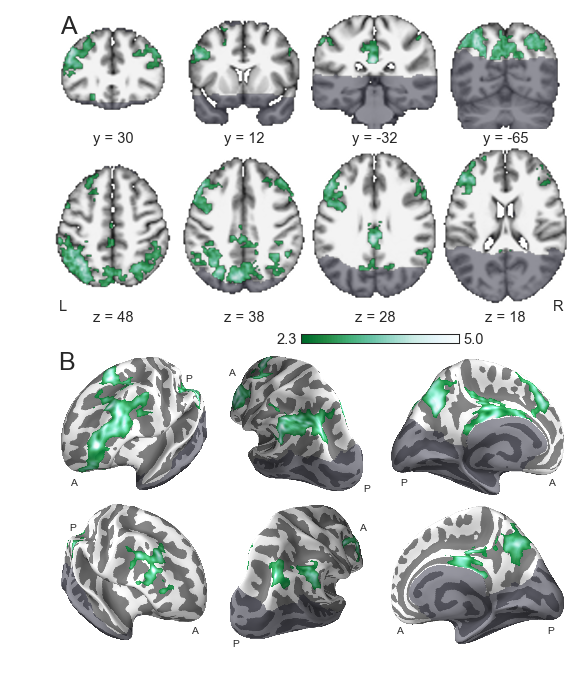

In [10]:
f = plt.figure(figsize=(3.5, 4.3))
gs = plt.GridSpec(14, 4)

# =========================================================================

# Draw the slices through the volume
cor_axes = [f.add_subplot(gs[:3, i]) for i in range(4)]
hor_axes = [f.add_subplot(gs[3:8, i]) for i in range(4)]

cor_slices = [30, 12, -32, -65]
hor_slices = [48, 38, 28, 18]

[slicer.plot_slice(ax, y=y) for ax, y in zip(cor_axes, cor_slices)]
[slicer.plot_slice(ax, z=z) for ax, z in zip(hor_axes, hor_slices)]

# Label the left/right sides of the brain
f.text(.02, .53, "L", size=7, ha="left")
f.text(.98, .53, "R", size=7, ha="right")

f.subplots_adjust(0, 0.15, .99, .99, wspace=.03, hspace=.03)

# =========================================================================

# Draw a colorbar for the statistical overlays
cbar_x, cbar_y = .48, .48
cbar_w, cbar_h = .3, .015
cbar_t = .485

with mpl.rc_context({"axes.linewidth": .5}):
    ax = f.add_axes([cbar_x, cbar_y, cbar_w, cbar_h])
slicer.plot_cmap(ax, vert=False)

# Add the min and max points
f.text(cbar_x - .01, cbar_t, "2.3",
       ha="right", va="center", size=7)
f.text(cbar_x + cbar_w +  .01, cbar_t, "5.0",
       ha="left", va="center", size=7)

# =========================================================================

# Plot the cortical surfaces
ax_pos = [(.02, .23, .28, .25), (.33, .25, .28, .21), (.65, .24, .33, .22),
          (.02, .00, .28, .25), (.33, .02, .28, .21), (.65, .01, .33, .22)]

axes = [f.add_axes(pos) for pos in ax_pos]
views = [("lh", "fro"), ("lh", "par"), ("lh", "med"),
         ("rh", "fro"), ("rh", "par"), ("rh", "med")]
for ax, (hemi, view) in  zip(axes, views):
    ax.imshow(cortex.snapshots[hemi][view], rasterized=True)
    ax.set_axis_off()

# Label the anterior and posterior poles of the surfaces
ap_pos = [((.04, .26), (.26, .42)), ((.34, .43), (.60, .25)), ((.95, .26), (.67, .26)),
          ((.27, .03), (.04, .19)), ((.59, .19), (.35, .01)), ((.66, .03), (.95, .03))]

for a, p in ap_pos:
    f.text(*a, s="A", size=5)
    f.text(*p, s="P", size=5)

# =========================================================================

# Label the panels
f.text(.02, .96, "A", size=12)
f.text(.02, .44, "B", size=12)

savefig(f, "brain_main")

----

## Main postive and negative correlations with task

In [11]:
slicer = SlicePlotter(model, "task",
                      stat_cmap="OrRd_r",
                      stat_thresh=2.3,
                      stat_range=(2, 6),
                      label_slices=False)

negslice = SlicePlotter(model, "task_neg",
                        stat_cmap="PuBu_r",
                        stat_thresh=2.3,
                        stat_range=(2, 6),
                        label_slices=False)

In [12]:
cortex = SurfacePlotter(model, "task")
kws = dict(thresh=2.3, min=2, max=6, alpha=.9)
cortex.add_data(colormap="OrRd_r", **kws)
cortex.add_data(contrast="task_neg", colormap="PuBu_r", **kws)
cortex.save_views("lat", "fro", "med", "par")
cortex.close()

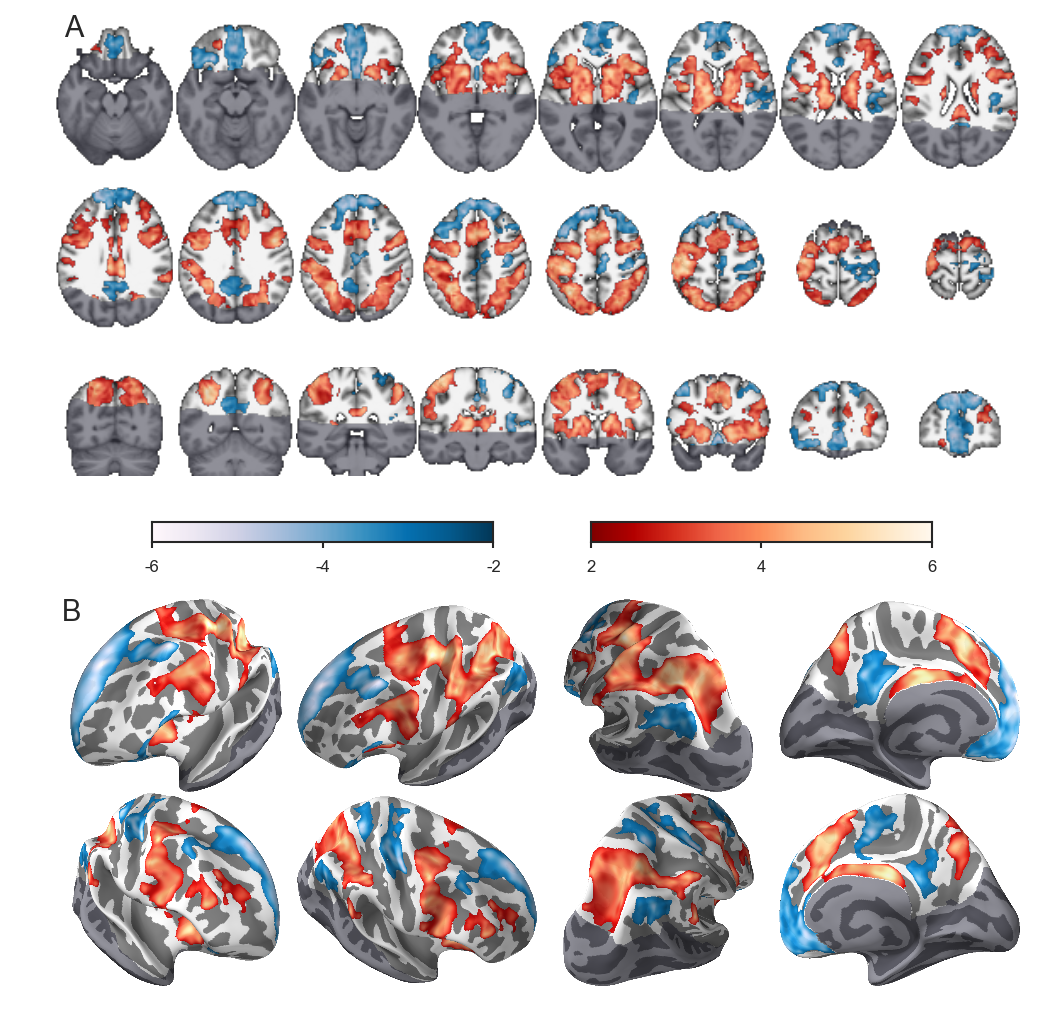

In [13]:
f, axes = plt.subplots(6, 8, figsize=(6.5, 6.6))

for ax in axes[3:].flat:
    ax.set_axis_off()
axes = axes[:3]

z_slices = np.linspace(-20, 70, len(axes[:-1].flat))
[slicer.plot_slice(ax, z=z) for ax, z in zip(axes[:].flat, z_slices)]
[negslice.plot_slice(ax, z=z, stat_only=True) for ax, z in zip(axes.flat, z_slices)]

y_slices = np.linspace(-70, 50, axes.shape[1])
[slicer.plot_slice(ax, y=y) for ax, y in zip(axes[-1], y_slices)]
[negslice.plot_slice(ax, y=y, stat_only=True) for ax, y in zip(axes[-1], y_slices)]

f.subplots_adjust(0, .01, .99, .99, 0, 0)

gs = plt.GridSpec(5, 4)
for i, hemi in enumerate(["lh", "rh"]):
    for j, view in enumerate(["fro", "lat", "par", "med"]):
        ax = f.add_subplot(gs[3 + i, j])
        ax.set_axis_off()
        ax.imshow(cortex.snapshots[hemi][view], rasterized=True)

cbar_axes = f.add_axes([.1, .46, .35, .02]), f.add_axes([.55, .46, .35, .02])
cbar = np.atleast_2d(np.linspace(-5, 5, 300))
for ax, cmap in zip(cbar_axes, ["PuBu", "OrRd_r"]):
    ax.pcolormesh(cbar, cmap=cmap, rasterized=True)
    ax.set(xticks=np.linspace(0, 300, 3), 
            yticks=[])
    ax.xaxis.tick_bottom()
cbar_axes[0].set_xticklabels([-6, -4, -2])
cbar_axes[1].set_xticklabels([2, 4, 6])

f.text(.01, .97, "A", size=14)
f.text(.01, .38, "B", size=14)

savefig(f, "brain_event")

---

## Conjunction between CPE and Reaction Time

In [14]:
def conjoin(zstat_temp, mask_temp):

    conjunction_name = "cpe_rt_conjunction"

    pe_img = nib.load(zstat_temp.format("cpe"))
    rt_img = nib.load(zstat_temp.format("response_time"))

    pe_data, rt_data = pe_img.get_data(), rt_img.get_data()
    conj = np.max([pe_data, rt_data], axis=0)
    conj[np.min([pe_data, rt_data], axis=0) == 0] = 0

    conj_img = pe_img.__class__(conj, pe_img.get_affine(), pe_img.get_header())
    conj_img.to_filename(zstat_temp.format(conjunction_name))

    shutil.copyfile(mask_temp.format("cpe"), mask_temp.format(conjunction_name))

In [15]:
conjunction_name = "cpe_rt_conjunction"
conjunction_temp = op.join(analysis_dir, experiment, "group/{}", conjunction_name)
paths = []
for space in ["mni", "fsaverage"]:
    path = conjunction_temp.format(space)
    if space == "fsaverage":
        for hemi in ["lh", "rh"]:
            hemi_path = "{}/{}/osgm".format(path, hemi)
            paths.append(hemi_path)
    else:
        paths.append(path)

for path in paths:
    if not op.exists(path):
        os.makedirs(path)

zstat_temp = op.join(analysis_dir, experiment, "group/mni/{}/zstat1_threshold.nii.gz")
mask_temp = op.join(analysis_dir, experiment, "group/mni/{}/mask.nii.gz")
conjoin(zstat_temp, mask_temp)

for hemi in ["lh", "rh"]:
    zstat_temp = op.join(analysis_dir, experiment, "group/fsaverage/{}", hemi,
                         "osgm/cache.th20.pos.sig.masked.mgh")
    mask_temp = op.join(analysis_dir, experiment, "group/fsaverage/{}", hemi, "mask.mgh")
    conjoin(zstat_temp, mask_temp)

In [16]:
pe = SlicePlotter(model, "cpe",
                  stat_cmap="BuGn_r",
                  stat_thresh=2.3,
                  stat_range=(1, 8),
                  label_slices=False)

rt = SlicePlotter(model, "response_time",
                  stat_cmap="RdPu_r",
                  stat_thresh=2.3,
                  stat_range=(1, 8),
                  label_slices=False)

conj = SlicePlotter(model, "cpe_rt_conjunction",
                    stat_cmap="YlOrBr_r",
                    stat_thresh=2.3,
                    stat_range=(-3, 6),
                    label_slices=False)

In [17]:
cortex = SurfacePlotter(model, "cpe")
kws = dict(thresh=2.3, min=1, max=8, alpha=.9)
cortex.add_data(colormap="BuGn_r", **kws)
cortex.add_data(contrast="response_time", colormap="RdPu_r", **kws)
kws.update(dict(min=-3, max=7))
cortex.add_data(contrast="cpe_rt_conjunction", colormap="YlOrBr_r", **kws)
cortex.save_views("lat", "fro", "med", "par")
cortex.close()

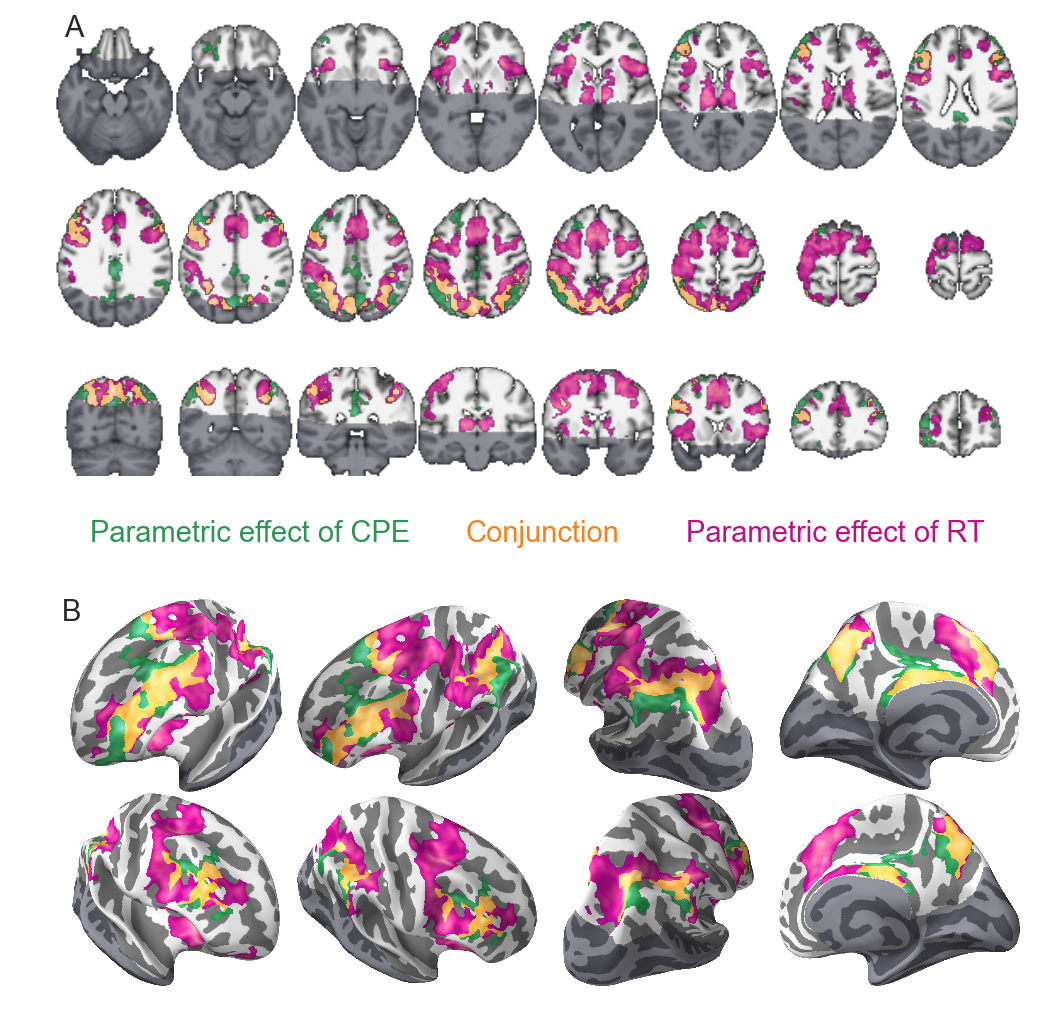

In [18]:
f, axes = plt.subplots(6, 8, figsize=(6.5, 6.6))

for ax in axes[3:].flat:
    ax.set_axis_off()
axes = axes[:3]

z_slices = np.linspace(-20, 70, len(axes[:-1].flat))
[pe.plot_slice(ax, z=z) for ax, z in zip(axes.flat, z_slices)]
[rt.plot_slice(ax, z=z, stat_only=True) for ax, z in zip(axes.flat, z_slices)]
[conj.plot_slice(ax, z=z, stat_only=True) for ax, z in zip(axes.flat, z_slices)]

y_slices = np.linspace(-70, 50, axes.shape[1])
[pe.plot_slice(ax, y=y) for ax, y in zip(axes[-1], y_slices)]
[rt.plot_slice(ax, y=y, stat_only=True) for ax, y in zip(axes[-1], y_slices)]
[conj.plot_slice(ax, y=y, stat_only=True) for ax, y in zip(axes[-1], y_slices)]

f.subplots_adjust(0, .01, .99, .99, 0, 0)

gs = plt.GridSpec(5, 4)
for i, hemi in enumerate(["lh", "rh"]):
    for j, view in enumerate(["fro", "lat", "par", "med"]):
        ax = f.add_subplot(gs[3 + i, j])
        ax.set_axis_off()
        ax.imshow(cortex.snapshots[hemi][view])

f.text(.20, .46, "Parametric effect of CPE", color="#2c9553", size=14, ha="center")
f.text(.50, .46, "Conjunction", color="#f4811d", size=14, ha="center")
f.text(.80, .46, "Parametric effect of RT", color="#bc1085", size=14, ha="center")

f.text(.01, .97, "A", size=14)
f.text(.01, .38, "B", size=14)

savefig(f, "brain_conjunction")

---

## Effect of CPE controlling for context switches

In [19]:
# Move the cpe parameter results from the main model output to the control model output
cpe_results = op.join(analysis_dir, "punch-cpe_context_switch/group/fsaverage/cpe_original")
if not op.exists(cpe_results):
    shutil.copytree(op.join(analysis_dir, "punch-cpe_main/group/fsaverage/cpe"),
                    cpe_results)

In [20]:
cortex = SurfacePlotter("cpe_context_switch", "cpe")
cortex.add_data(colormap="BuGn_r", thresh=2.3, min=2, max=5, alpha=1)
cortex.add_data(colormap="BuGn_r", thresh=2.58, min=2, max=5, corrected=False, alpha=.75)
cortex.add_data_contour(contrast="cpe_original", thresh=2.3, min=0, max=1.2,
                        n_contours=2, line_width=8, colormap="Greys")
cortex.save_views("fro", "par", "lat", "med")
cortex.close()

In [21]:
slicer = SlicePlotter("cpe_main", "cpe", sharp=True, stat_cmap="BuGn_r", stat_range=(2, 5))

This next cell assumes that the ROI timecourse data has been cached. That can be accomplished with the following code

    rois = ['yeo17_ifs', 'yeo17_ips', 'yeo17_mspl', 'yeo17_pcc']
    import punch_utils
    punch_utils.cache_roi_timecourses(rois)

In [22]:
rois = ["IFS", "IPS", "mSPL", "PCC"]
masks = ["yeo17_" + r.lower() for r in rois]
cpe_quartiles_df = estimate_roi_firs(masks, "cpe_quartiles_with_switch")

In [23]:
cpe_quartiles_df = cpe_quartiles_df.query("timepoint == 5")
cpe_quartiles_df = cpe_quartiles_df.loc[cpe_quartiles_df.condition.str.startswith("cpe")]
cpe_quartiles_df["cpe"] = cpe_quartiles_df.condition.str[-1].astype(int)

/Users/mwaskom/anaconda/envs/punch/lib/python2.7/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mwaskom/anaconda/envs/punch/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


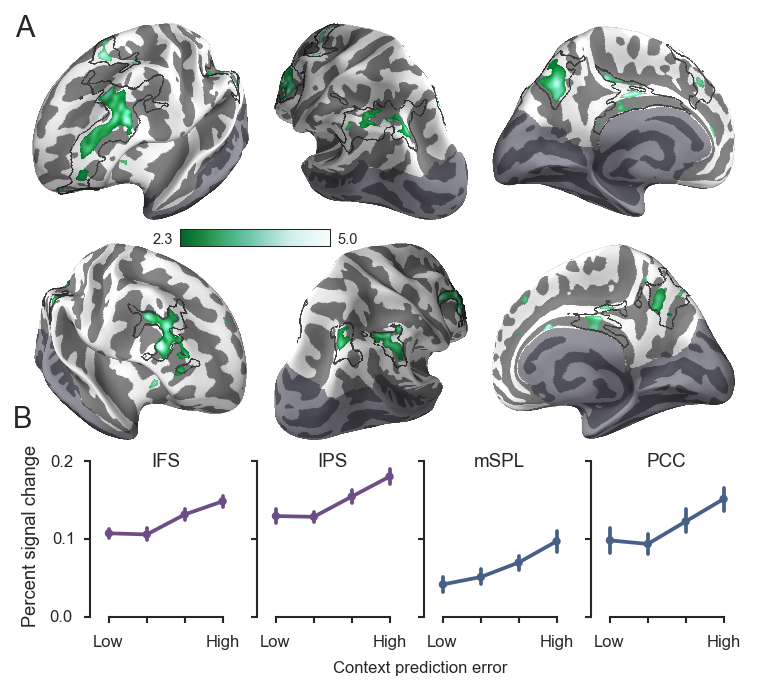

In [24]:
f, axes = plt.subplots(2, 3, figsize=(5, 3),
                       gridspec_kw=dict(width_ratios=[.9, .8, 1]))

# Plot the surfaces
for ax_row, hemi in zip(axes, ["lh", "rh"]):
    for ax, view in zip(ax_row, ["fro", "par", "med"]):
        ax.imshow(cortex.snapshots[hemi][view], rasterized=True)
        ax.set(xticks=[], yticks=[])
        ax.set_axis_off()
f.tight_layout()
f.set_figheight(4.5)
f.subplots_adjust(bottom=.36, top=.98)

# Plot a colorbar
with mpl.rc_context({"axes.linewidth": .5}):
    cbar_ax = f.add_axes([.23, .65, .2, .025])
slicer.plot_cmap(cbar_ax, vert=False)
f.text(.22, .66, "2.3",
       ha="right", va="center", size=7)
f.text(.44, .66, "5.0",
       ha="left", va="center", size=7)

# Set up axes for the ROI plots
roi_grid = plt.GridSpec(2, 4, height_ratios=[.7, .3],
                         left=.11, bottom=.10, right=.98, top=.95)
roi_axes = [f.add_subplot(roi_grid[-1, c]) for c in range(4)]

purple, blue = "#6c4d87", "#476087"

for i, (roi, ax) in enumerate(zip(rois, roi_axes)):

    # Pull out the data for this ROI
    mask = "yeo17_" + roi.lower()
    peak_df = cpe_quartiles_df.query("roi == '{}'".format(mask))
    peak_df = moss.remove_unit_variance(peak_df, "coef", "subj")

    # Draw as a pointplot
    color = purple if i < 2 else blue
    sns.pointplot("condition", "coef_within", data=peak_df,
                  order=["cpe_1", "cpe_2", "cpe_3", "cpe_4"],
                  color=color, n_boot=10000, ax=ax)
    ax.collections[0].set_sizes([7])

    # Annotate the axes appropriately
    if i:
        ax.set(yticklabels=[])
    ax.text(1.5, .2, roi, size=9, ha="center", va="center")
    ax.set(xlabel="", xticklabels=["Low", "", "", "High"],
           ylabel="", ylim=(0, .21), yticks=[0, .1, .2])
    sns.despine(ax=ax, trim=True)

roi_axes[0].set_ylabel("Percent signal change")
f.text(.55, .025, "Context prediction error", size=8, ha="center", va="center")

f.text(.01, .96, "A", size=14)
f.text(.01, .38, "B", size=14)

savefig(f, "switch_control")